<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-ft-densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 41.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

!unzip {path}
!reset

In [9]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
import torchvision
from torch.profiler import profile, record_function, ProfilerActivity

import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(img_path)
    image = Image.fromarray(image.pixel_array).convert(mode='RGB')

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

  def get_classes(self):
    return self.img_labels.iloc[:, -1].unique()

  classes = property(get_classes)

In [11]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.5, stratify=X_test.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())

len(X_train), len(X_val),  len(X_test)

(24181, 3023, 3023)

In [12]:
mean = [0.5132, 0.5132, 0.5132]
std = [0.2168, 0.2168, 0.2168]

transforms = dict(
  train = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.RandomHorizontalFlip(.2),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ]),
  val = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ])
)

datasets = dict(
    train=CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=transforms['train']),
    val=CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=transforms['val']),
    test=CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=transforms['val']),
)

In [13]:
batch_size = 32

data_loaders = dict(
    train=DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    val=DataLoader(datasets['val'], batch_size=batch_size, shuffle=True),
    test=DataLoader(datasets['test'], batch_size=batch_size),
)

dataset_sizes = {x:len(datasets[x]) for x in ('train', 'val', 'test')}

print('training steps per epoch:', dataset_sizes['train']//batch_size)
print('validation steps per epoch:', dataset_sizes['val']//batch_size)
print('test steps per epoch:', dataset_sizes['test']//batch_size)

training steps per epoch: 755
validation steps per epoch: 94
test steps per epoch: 94


In [ ]:
# Uncomment and run to get mean and standard deviation
# for x, y in data_loaders['train']:
#   break

# x.mean(dim=(0, 2, 3)), x.std(dim=(0, 2, 3))

In [ ]:
feature_extract = False

model = torchvision.models.densenet121(weights='DEFAULT')
# Freeze all layers if feature extract
if feature_extract:
  for params in model.parameters():
    params.requires_grad=False

# add final layer with # outputs in same dimension of labels
# these layers will have params.requires_grad=True
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If feature extraction, only optimize/update the feautres in the
# classifer layer
if feature_extract:
  params_to_update = []
  for name,param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t", name)
# Else, we update all features.
else:
  params_to_update = model.parameters()
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      print("\t", name)

model = model.to(device)

zero, one = label_df.iloc[X_train].Target.value_counts().tolist()

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([zero/one]).to(device))
optimizer = SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [59]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 1e+8

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    for phase in ('train', 'val'):
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for (inputs, labels) in data_loaders[phase]:
        inputs = inputs.to(device)
        labels = labels.reshape(-1, 1).float().to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          preds = (outputs >= 0.0).float()
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      lr = next(iter(optimizer.param_groups))['lr']

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {lr:6f}')

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Loss: {best_loss:4f}')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [60]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.6148 Acc: 0.7822 LR: 0.001000
val Loss: 0.5625 Acc: 0.7899 LR: 0.001000
Epoch 1/3
----------
train Loss: 0.5442 Acc: 0.8100 LR: 0.000100
val Loss: 0.5357 Acc: 0.8210 LR: 0.000100
Epoch 2/3
----------
train Loss: 0.4608 Acc: 0.8453 LR: 0.000100
val Loss: 0.5233 Acc: 0.8376 LR: 0.000100
Epoch 3/3
----------
train Loss: 0.4244 Acc: 0.8608 LR: 0.000010
val Loss: 0.5172 Acc: 0.8329 LR: 0.000010
Training complete in 41m 46s
Best val Loss: 0.517155
Best val Acc: 0.832947


In [61]:
running_labels = torch.Tensor(0, 1).to(device)
running_outputs = torch.Tensor(0, 1).to(device)

with torch.no_grad():
  model.eval()
  for i, (inputs, labels) in enumerate(data_loaders['test']):
    inputs, labels = inputs.to(device), labels.reshape(-1, 1).float().to(device)

    outputs = model(inputs)

    running_labels = torch.cat((running_labels, labels), dim=0)
    running_outputs = torch.cat((running_outputs, outputs), dim=0)

precision:	0.7121
recall:		0.8462
f1:		0.7734



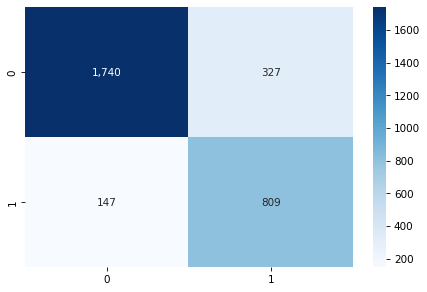

In [62]:
y_true = running_labels.cpu().numpy()
y_pred = (running_outputs>=0.0).float().cpu().numpy()
y_proba = torch.nn.Sigmoid()(running_outputs).cpu().numpy()

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

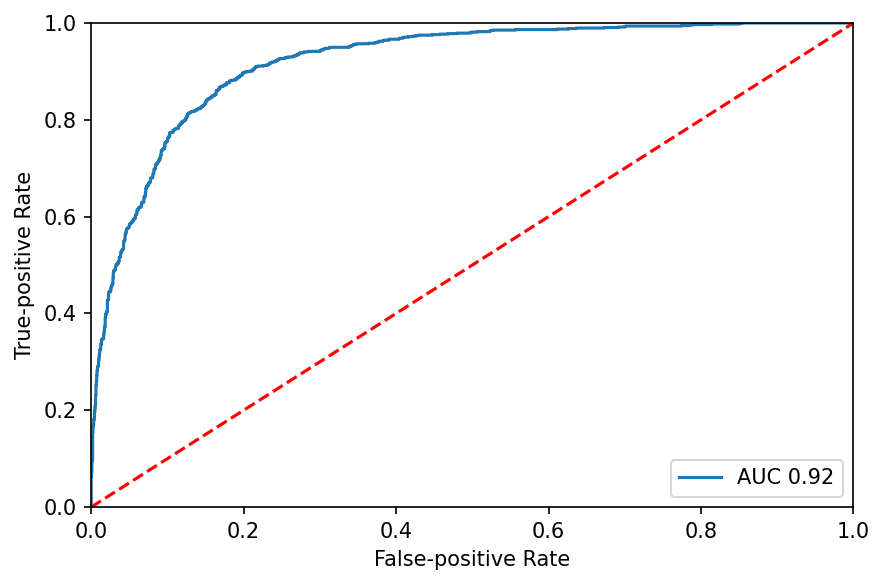

In [63]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

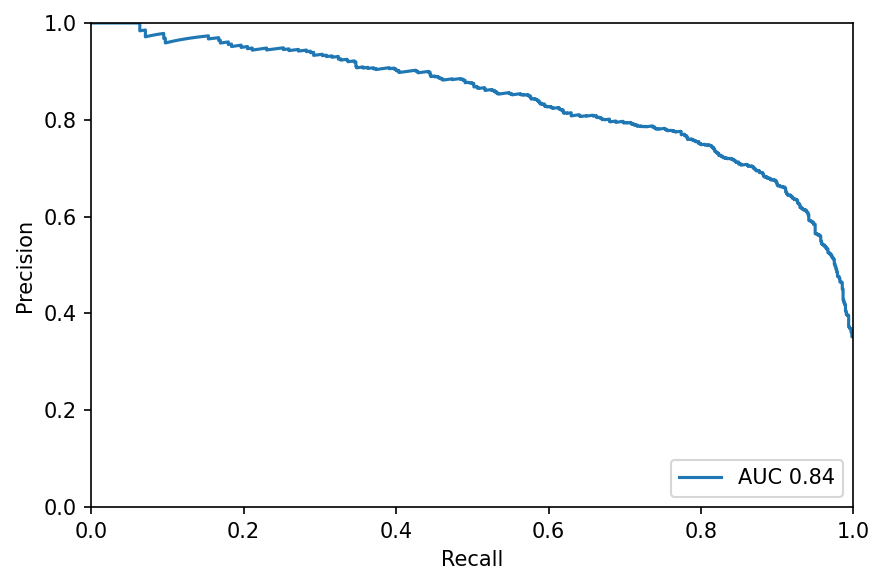

In [64]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()

In [ ]:
# Save model
path = '/content/drive/MyDrive/capstone/models/tim-densenet-121-ft'

torch.save({
    'train_ix':X_train, 
    'val_ix':X_val, 
    'test_ix':X_test,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
  },
  path
)